# Fidelity-Interpretability analysis on the CIFAR10 dataset.

In [1]:
import sys
sys.path.append('..')

from utils.plotting import *

%matplotlib inline

/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.

Load the baseline and the logs.

In [2]:
baseline_loc = '../results/cifar10/seeker/default/baseline.txt'
with open(baseline_loc) as f:
    baseline = float(f.read())
print('Baseline accuracy: {:.2f}%'.format(baseline * 100))

# Deterministic
experiment_dir = '../logs/cifar10/hns/deterministic/full_training_10/'
det_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
det_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# ST
experiment_dir = '../logs/cifar10/hns/stochastic/st1/full_training_10/'
st1_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
st1_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

# SA-0.1
experiment_dir = '../logs/cifar10/hns/stochastic/sa/rate_0.1/full_training_10/'
sa_epoch_logs = load_and_process_epoch_logs_from_dir(experiment_dir)
sa_batch_logs = load_and_process_batch_logs_from_dir(experiment_dir)

W0916 12:32:47.296380 139739125974784 deprecation.py:323] From /home/thanos/.envs/dl/lib/python3.5/site-packages/tensorflow/python/summary/summary_iterator.py:68: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Baseline accuracy: 65.37%


Compute the Fidelity the Interpretability and the FIR.

In [3]:
x = np.linspace(0, len(det_batch_logs[0]), len(det_epoch_logs[0]))

det = pd.concat(det_epoch_logs)
st1 = pd.concat(st1_epoch_logs)
sa = pd.concat(sa_epoch_logs)

det['Fidelity'] = det['Validation accuracy'] / baseline * 100
st1['Fidelity'] = st1['Validation accuracy'] / baseline * 100
sa['Fidelity'] = sa['Validation accuracy'] / baseline * 100

det['Interpretability'] = pd.concat([
    det_batch_logs[i]['percentage hidden'][x.astype(int)].fillna(det_batch_logs[i]['percentage hidden'].iloc[-1])
    for i in range(len(det_batch_logs))]).values

st1['Interpretability'] = pd.concat([
    st1_batch_logs[i]['percentage hidden'][x.astype(int)].fillna(st1_batch_logs[i]['percentage hidden'].iloc[-1])
    for i in range(len(st1_batch_logs))]).values

sa['Interpretability'] = pd.concat([
    sa_batch_logs[i]['percentage hidden'][x.astype(int)].fillna(sa_batch_logs[i]['percentage hidden'].iloc[-1])
    for i in range(len(sa_batch_logs))]).values

det['FIR'] = det['Fidelity'] / (det['Fidelity'] + det['Interpretability'])
st1['FIR'] = st1['Fidelity'] / (st1['Fidelity'] + st1['Interpretability'])
sa['FIR'] = sa['Fidelity'] / (sa['Fidelity'] + sa['Interpretability'])

det['FI'] = det['Fidelity'] * det['Interpretability'] / 100
st1['FI'] = st1['Fidelity'] * st1['Interpretability'] / 100 
sa['FI'] = sa['Fidelity'] * sa['Interpretability'] / 100

/home/thanos/.envs/dl/lib/python3.5/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


See how the models' classification performance improves through training.

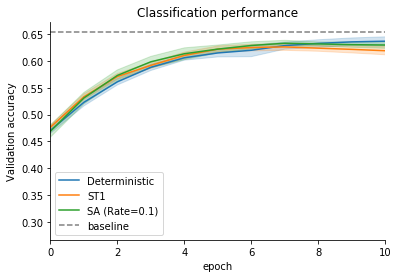

In [4]:
sns.lineplot(x='step', y='Validation accuracy', data=det, label='Deterministic')
sns.lineplot(x='step', y='Validation accuracy', data=st1, label='ST1')
sns.lineplot(x='step', y='Validation accuracy', data=sa, label='SA (Rate=0.1)')

plt.plot(sa_epoch_logs[0]['step'], [baseline] * len(sa_epoch_logs[0]), 
         label='baseline', c='0.5', ls='--')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('Classification performance')

plt.xlim([0, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

See how the fidelity of the models improves.

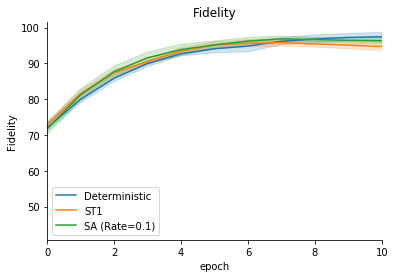

In [5]:
sns.lineplot(x='step', y='Fidelity', data=det, label='Deterministic')
sns.lineplot(x='step', y='Fidelity', data=st1, label='ST1')
sns.lineplot(x='step', y='Fidelity', data=sa, label='SA (Rate=0.1)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('Fidelity')

plt.xlim([0, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

PLot the interpretability of the models.

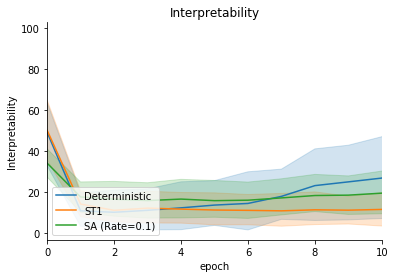

In [6]:
sns.lineplot(x='step', y='Interpretability', data=det, label='Deterministic')
sns.lineplot(x='step', y='Interpretability', data=st1, label='ST1')
sns.lineplot(x='step', y='Interpretability', data=sa, label='SA (Rate=0.1)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('Interpretability')

plt.xlim([0, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Plot the FIR

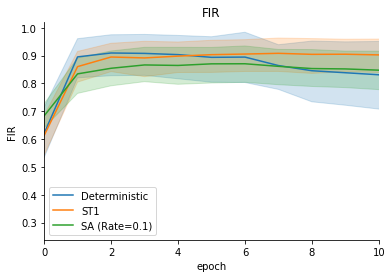

In [7]:
sns.lineplot(x='step', y='FIR', data=det, label='Deterministic')
sns.lineplot(x='step', y='FIR', data=st1, label='ST1')
sns.lineplot(x='step', y='FIR', data=sa, label='SA (Rate=0.1)')

plt.legend(loc='lower left')
plt.xlabel('epoch')

plt.title('FIR')

plt.xlim([0, 10])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Compute metrics for the "best model".

In [8]:
sa.iloc[np.argmax(sa['FI'].values)]

Average loss per epoch     0.304374
Validation accuracy        0.641895
step                      20.000000
Fidelity                  98.197237
Interpretability          96.672554
FIR                        0.503912
FI                        94.929777
Name: 20, dtype: float64